In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import cmocean
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cftime
import datetime

# %load_ext autoreload
# %autoreload 2

In [3]:
# make a dummy time index

length = 1200; start_date = '31/1/2001';
time = pd.date_range(start = start_date, periods=length, freq='M')
dummy_time=xr.Dataset({"time": time})

# Load SLP data

First I load the data I downloaded from globus server. I kind of pre-process it so that it is just one file, I rename sst, and regrid a bit.
Then I save it again. 
The renaming and regridding is not so necessary in this case but I do it for all the models so just copied the code.
My folder naming you can adjust, so that it works for you!

In [ ]:
## HadCM3

# files per year

folder = 'PlioMIP2 data/'
model = 'HadCM3'

# E280
sim = 'E280'

# get all files

file = 'e280_corr.MSLP.0'
file0 = 'e280_corr.MSLP.000.nc'

# file of year 0
ds = xr.open_dataset(folder+model+'/'+sim+'/'+file0, decode_times=False).p.isel(msl=0)

# loop over years
ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+model+'/'+sim+'/'+file+years, decode_times=False).p.isel(msl=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")
    
# create netcdf dataset
slp = 0.01*ds.sortby("lat")
data = xr.DataArray(data = slp,
             dims = ["time", "lat", "lon"],
             coords = dict(time = dummy_time.time,
                           lat  = ds.lat,
                           lon  = ds.lon),
             attrs = dict(units = 'hPa',
                          description = 'Sea-level pressure'))

ds = data.to_dataset(name='slp')
ds.attrs['model'] = model
ds.attrs['sim'] = sim
ds.to_netcdf(folder+model+'/'+sim+'/E280_slp_monthly.nc', mode = 'w')

# similar for Eoi400

# Eoi400
sim = 'Eoi400'

# get all files

file = 'eoi400.MSLP.0'

file0 = 'eoi400.MSLP.000.nc'
ds = xr.open_dataset(folder+model+'/'+sim+'/'+file0, decode_times=False).p.isel(msl=0)

ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+model+'/'+sim+'/'+file+years, decode_times=False).p.isel(msl=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")
    
slp = 0.01*ds.sortby("lat")
data = xr.DataArray(data = slp,
             dims = ["time", "lat", "lon"],
             coords = dict(time = dummy_time.time,
                           lat  = ds.lat,
                           lon  = ds.lon),
             attrs = dict(units = 'hPa',
                          description = 'Sea-level pressure'))

ds = data.to_dataset(name='slp')
ds.attrs['model'] = model
ds.attrs['sim'] = sim
ds.to_netcdf(folder+model+'/'+sim+'/Eoi400_slp_monthly.nc', mode = 'w')


### Repeat the same for SST data 

# Load SST data

In [ ]:
folder = 'PlioMIP2 SST data/models/HadCM3/E280_corr/'
# folder = 'PlioMIP2 SST data/models/HadCM3/E280/'

# get all files

file = 'e280_corr.SST.0'
file0 = 'e280_corr.SST.000.nc'

ds = xr.open_dataset(folder+file0, decode_times=False).temp.isel(unspecified=0)

# loop over years
ylen = 100
for yi in range(1,ylen):

    if yi<10: years = f'0{yi}.nc';
    else:     years = f'{yi}.nc';
    
    ds_ = xr.open_dataset(folder+file+years, decode_times=False).temp.isel(unspecified=0)
    
    ds = xr.concat([ds, ds_], dim="t")

ds=ds.rename({"latitude":"lat"}).rename({"longitude":"lon"}).sortby("lat")

# load a reference for regridding (optional)
ref_path = 'PlioMIP2 data/CCSM4/E280/E280_sst_monthly.nc'
ds_ref = xr.open_dataset(ref_path, decode_times=False)
    
# regrid!
sst = ds.interp_like(ds_ref)
sst = sst.drop("unspecified").rename({"t":"time"})

# save as netcdf
sst = sst.to_dataset(name="sst")
sst["time"] = dummy_time.time
sst.sst.attrs['units'] = 'deg C'
sst.sst.attrs['description'] = 'SSTs'
sst.attrs['model'] = 'HadCM3'
sst.attrs['sim'] = 'E280'

sst_reg.to_netcdf('PlioMIP2 data/HadCM3/E280/E280_sst_monthly.nc', mode = 'w')

##
##
##

# repeat for Eoi400 (I used the regridded Eoi400 data you supplied me a few years ago, and that seems to be the same as currently on the server!)

# Now, some checks

In [4]:
model = 'HadCM3'
folder = 'PlioMIP2 data'
sim1 = "E280"; 
sim2 = "Eoi400";
slp_name = "_slp_monthly.nc"
sst_name = "_sst_monthly.nc"


## We start with Eoi400

In [10]:
# First we check Eoi400 as reference (can also check another model if you have the data at hand)

sim = sim2

# open SST
file = folder+"/"+model+"/"+sim+"/"+sim+sst_name
sst2  = xr.open_dataset(file); 

# open SLP
file = folder+"/"+model+"/"+sim+"/"+sim+slp_name
slp2  = xr.open_dataset(file);

In [99]:
# compute climatologies and anomalies

sst2_clim = sst2.groupby('time.month').mean('time')
slp2_clim = slp2.groupby('time.month').mean('time')

sst2_anom = sst2.groupby('time.month') - sst2_clim
slp2_anom = slp2.groupby('time.month') - slp2_clim

First let's see if the SST and SLP are truly SST and SLP (an obvious thing, but lets be sure!)

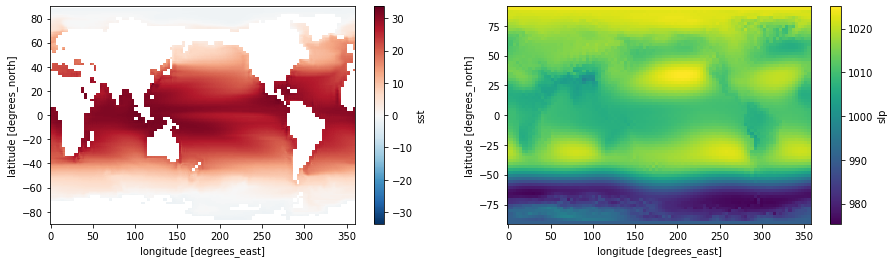

In [110]:
fig = plt.figure(figsize = (15,4))

ax = fig.add_subplot(1,2,1)
sst2_clim.sst.mean("month").plot(ax=ax)

ax = fig.add_subplot(1,2,2)
slp2_clim.slp.mean("month").plot(ax=ax)

That seems about right

Now, let's make some correlations

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(1.0, 1.0, 'E280')

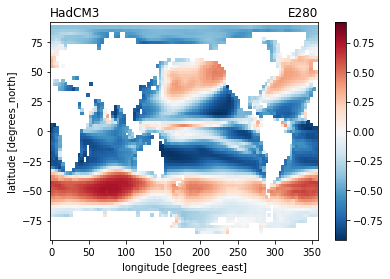

In [113]:
# correlate straight SSTs and SLPs

fig = plt.figure()

# interpolate one or the other so that we can compute correlations per lat,lon point
sst2_ = sst.interp_like(slp2)

ax = fig.add_subplot(1,1,1)

# compute and plot correlation
xr.corr(slp2.slp, sst2_.sst, dim="time").plot(ax=ax)
ax.set_title(model, loc='left')
ax.set_title(sim, loc='right')
    

Now we expect that - regardless of the years - here a correlation pattern will show, because there is a seasonal cycle 

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(1.0, 1.0, 'Eoi400')

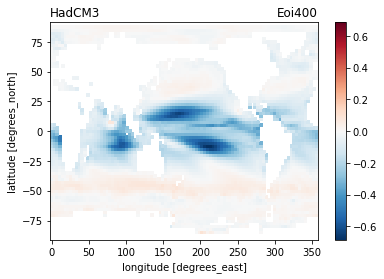

In [13]:
# correlate SSTs and SLPs anomalies

fig = plt.figure()

# interpolate one or the other so that we can compute correlations per lat,lon point
sst2_anom_ = sst2.interp_like(slp2_anom)

ax = fig.add_subplot(1,1,1)

# compute and plot correlation
xr.corr(slp2_anom.slp, sst2_anom_.sst, dim="time").plot(ax=ax)
ax.set_title(model, loc='left')
ax.set_title(sim, loc='right')

This is a correlation pattern that almost all models and simulations show, both E280 and Eoi400, albeit differences. 

As we will see, the HadCM3 E280 data shows something very different!

## Now we look at E280

In [14]:

sim = sim1

# open SST
file = folder+"/"+model+"/"+sim+"/"+sim+sst_name
sst1  = xr.open_dataset(file); 

# open SLP
file = folder+"/"+model+"/"+sim+"/"+sim+slp_name
slp1  = xr.open_dataset(file);

In [15]:
# compute climatologies and anomalies

sst1_clim = sst1.groupby('time.month').mean('time')
slp1_clim = slp1.groupby('time.month').mean('time')

sst1_anom = sst1.groupby('time.month') - sst1_clim
slp1_anom = slp1.groupby('time.month') - slp1_clim

Again, first let's quickly check mean SST and mean SLP

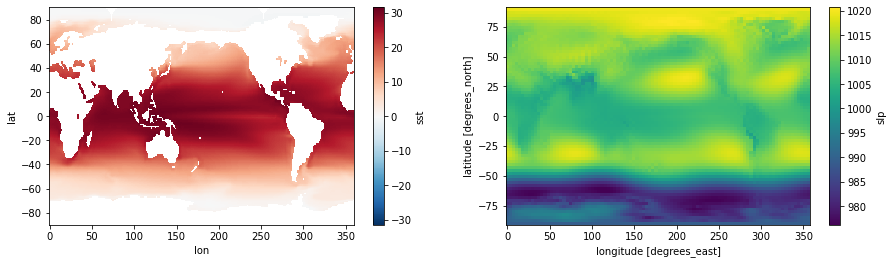

In [111]:
fig = plt.figure(figsize = (15,4))

ax = fig.add_subplot(1,2,1)
sst1_clim.sst.mean("month").plot(ax=ax)

ax = fig.add_subplot(1,2,2)
slp1_clim.slp.mean("month").plot(ax=ax)

Again, that looks good! So we are sure that the variables represent SST and SLP

Now, let's make some correlation maps again

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(1.0, 1.0, 'E280')

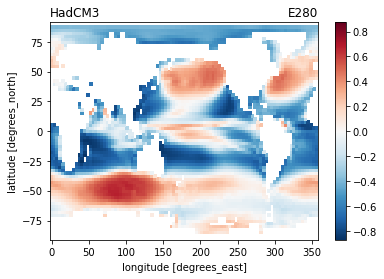

In [16]:
# correlate straight SSTs and SLPs

fig = plt.figure()

# interpolate one or the other so that we can compute correlations per lat,lon point
sst1_ = sst.interp_like(slp1)

ax = fig.add_subplot(1,1,1)

# compute and plot correlation
xr.corr(slp1.slp, sst1_.sst, dim="time").plot(ax=ax)
ax.set_title(model, loc='left')
ax.set_title(sim, loc='right')
    

As expected the correlation between SLP and SST without climatology taken off looks similar. Basically subtropical high and subpolar low variations that are opposite in the ocean.

/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(1.0, 1.0, 'E280')

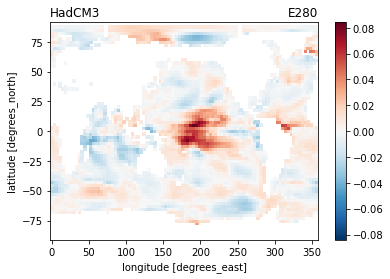

In [18]:
# correlate SSTs and SLPs anomalies

fig = plt.figure()

# interpolate one or the other so that we can compute correlations per lat,lon point
sst1_anom_ = sst1.interp_like(slp1_anom)

ax = fig.add_subplot(1,1,1)

# compute and plot correlation
xr.corr(slp1_anom.slp, sst1_anom_.sst, dim="time").plot(ax=ax)
ax.set_title(model, loc='left')
ax.set_title(sim, loc='right')

As you can see, now the correlation is basically zero everywhere (highest value 0.08....). To me it indicates that the SLP and SST data is not the same years.

## Now some indices in time

In [19]:
# Now we average over a small region where we see strong (anti)correlation in the Eoi400; a square in the southern equatorial central Pacific.
# basically a southward shifted Nino3.4 region! Here we see strong (anti)correlation between Eoi400 SLP and SST



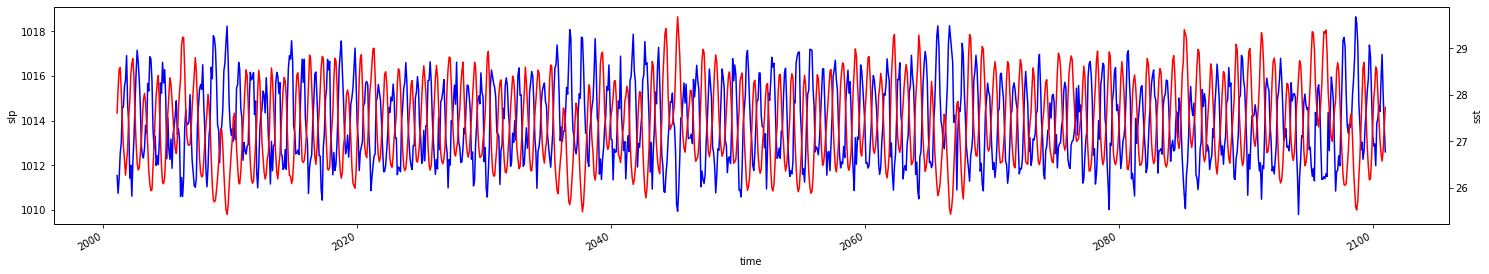

In [35]:
# first let's check the index with no climatology taken off

sst2_index = sst2.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp2_index = slp2.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)

slp2_index.plot(ax=ax, color='b')
ax2 = ax.twinx()
sst2_index.plot(ax=ax2, color='r')

In [21]:
# correlation coefficient:

np.corrcoef(sst2_index, slp2_index)[1,0]

-0.8641082208382113

a strong correlation! Yes, because the seasonal cycle... Now let's use anomalies

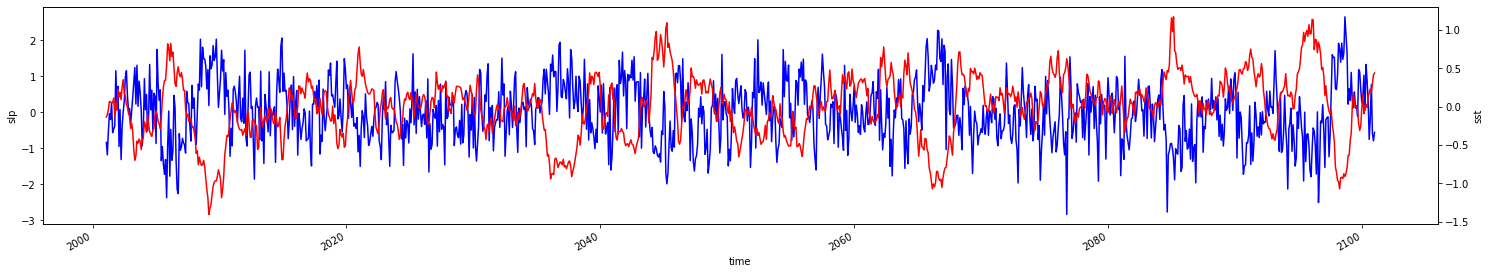

In [22]:
# then, the anomalies

sst2_index = sst2_anom.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp2_index = slp2_anom.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)

slp2_index.plot(ax=ax, color='b')
ax2 = ax.twinx()
sst2_index.plot(ax=ax2, color='r')

In [23]:
# correlation coefficient:

np.corrcoef(sst2_index, slp2_index)[1,0]

-0.5963014131556149

A pretty strong anticorrelation. Which was to be expected from the earlier figure of correlations, in this region. Qualitatively, it checks out

Now, ENSO reduced in strength in the midPliocene. And my (prelim) results show that the atmospheric teleconnections seem to reduce. \
So, I would expect that the correlations in the E280 would be stronger

### Now for the E280..

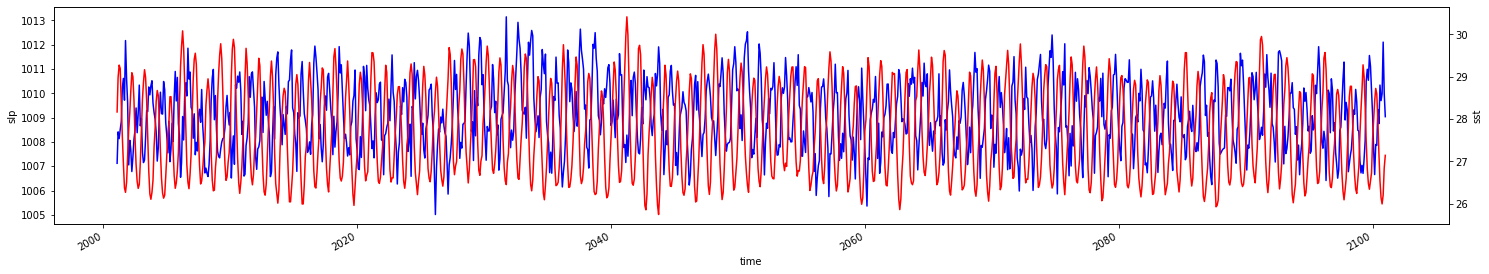

In [34]:
# first let's check the index with no climatology taken off

sst1_index = sst1.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp1_index = slp1.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)

slp1_index.plot(ax=ax, color='b')
ax2 = ax.twinx()
sst1_index.plot(ax=ax2, color='r')

In [25]:
# correlation coefficient:

np.corrcoef(sst1_index, slp1_index)[1,0]

-0.716943440466493

Again, a pretty strong correlation. Expected, because its the seasonal cycle. Still it's a lower correlation compared to Eoi400 (~0.86).

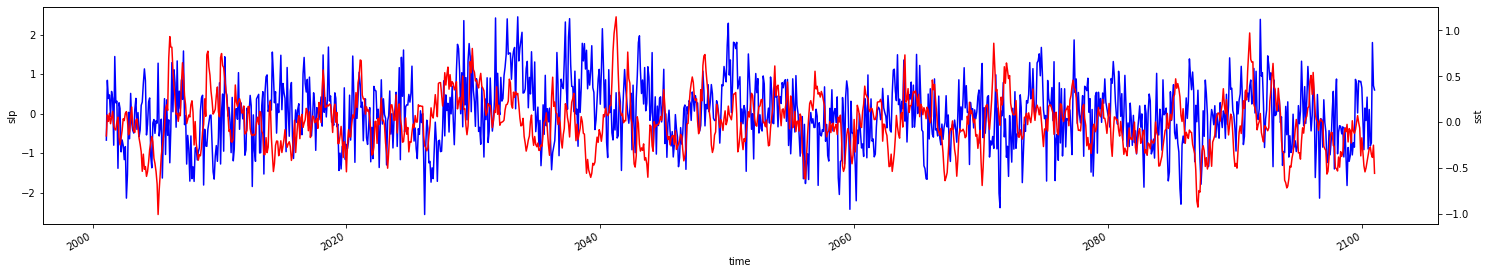

In [28]:
# Now lets check the anomalies

sst1_index = sst1_anom.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp1_index = slp1_anom.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)

slp1_index.plot(ax=ax, color='b')
ax2 = ax.twinx()
sst1_index.plot(ax=ax2, color='r')

In [29]:
# correlation coefficient:

np.corrcoef(sst1_index, slp1_index)[1,0]

0.0750665418200434

Now, the correlation is near zero. Basically, these SLP and SST indices do not correlate... Also qualitatively it does not really look like they are the opposite.

## Maybe there is a small lead/lag in the data?

I think I can check with this data, is whether there is an offset in the years of a few months or years. \
It might be unlikely, but I think worth to check. Esp since that is also hard to check by eye

In [90]:
# I consider a long lag but max 900 months. At some lengths, the data you are comparing are just a few years. 
# So, the correlation becomes difficult to interpret.
# in fact what happens is the shifted data is filled with nans and so the correlation coefficient becomes meaningless with too many nan values

nlag = 900;

lag  = np.arange(-nlag, nlag+1)

### First, Eoi400 check

In [91]:
# first let's check the index with no climatology taken off

sst2_index = sst2.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp2_index = slp2.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

corr2 = np.zeros(len(lag))

for j in range(len(lag)):
    slp2_index_lag = slp2_index.shift(time=lag[j])
    
    corr2[j] = xr.corr(sst2_index, slp2_index_lag, "time")


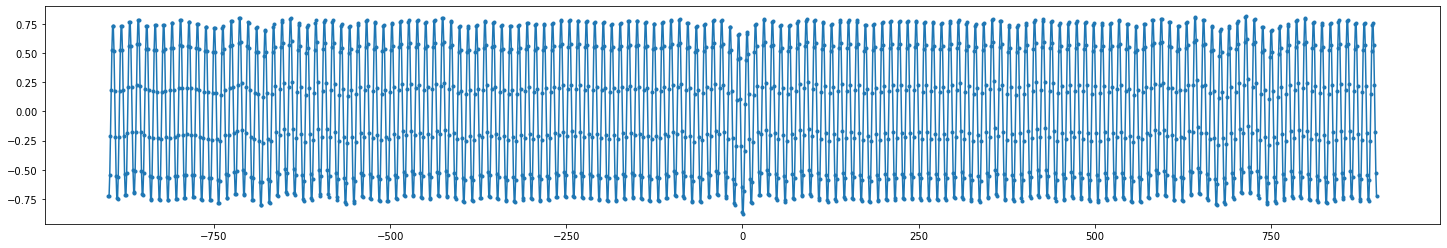

In [92]:
fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)    

ax.plot(lag, corr2, '.-')

As expected there is a seasonal cycle in the lead/lag correlation. 

In [93]:
# then, the anomalies

sst2_index = sst2_anom.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp2_index = slp2_anom.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

corr2 = np.zeros(len(lag))

for j in range(len(lag)):
    slp2_index_lag = slp2_index.shift(time=lag[j])
    
    corr2[j] = xr.corr(sst2_index, slp2_index_lag, "time")

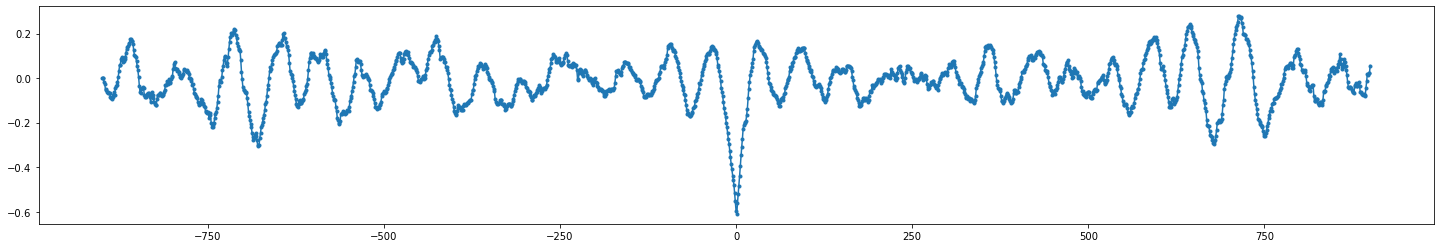

In [94]:
fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)    

ax.plot(lag, corr2, '.-')

Here we can see a strong (anti)correlation at lag ~0., and in no other period in the timeseries is there a more pronounced peak

The value at lag 0 is around -0.6, which is indeed what we found earlier. 

Not sure what happens in the rest of the leadlag graph. Maybe some decadal or centennial scale variations? Very interesting, but also very small correlations (roughly < .2)

### Now lets see what the E280 does

In [95]:
# first let's check the index with no climatology taken off

sst1_index = sst1.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp1_index = slp1.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

corr1 = np.zeros(len(lag))

for j in range(len(lag)):
    slp1_index_lag = slp1_index.shift(time=lag[j])
    
    corr1[j] = xr.corr(sst1_index, slp1_index_lag, "time")


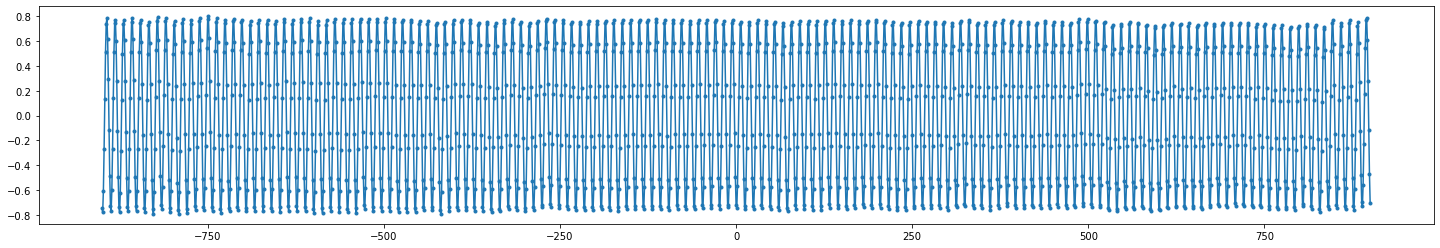

In [96]:
fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)    

ax.plot(lag, corr1, '.-')

Again as expected here strong seasonal cycle correlations!

In [97]:
# then, the anomalies

sst1_index = sst1_anom.sst.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")
slp1_index = slp1_anom.slp.sel(lat=slice(-25, -5)).sel(lon=slice(190, 240)).mean("lat").mean("lon")

corr1 = np.zeros(len(lag))

for j in range(len(lag)):
    slp1_index_lag = slp1_index.shift(time=lag[j])
    
    corr1[j] = xr.corr(sst1_index, slp1_index_lag, "time")

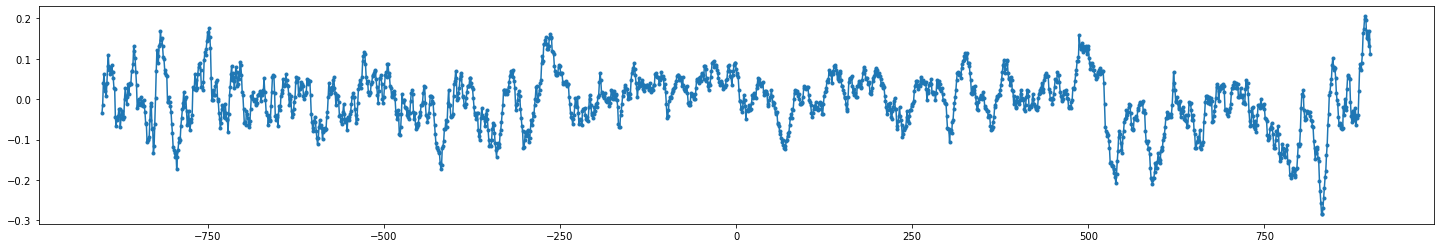

In [98]:
fig = plt.figure(figsize=(25,4))
ax = fig.add_subplot(111)    

ax.plot(lag, corr1, '.-')

Now we can clearly see that: 1. there is no correlation at lag 0; 2. there is no obvious other peak 

This indicates that the data does not correlate and is also not shifted (at least not a few years or decades)

# Now what ...?

I am pretty sure that:
the E280 data is not corrupted, both not the SST or SLP data. The data seems to be fine and it seems to represent proper dynamics. 

So, what could be wrong..?

I think of three options:
1. <b>The E280 data on the Globus server is correct, but I am making a mistake in the pre-processing of the E280 data.</b>
Although I have checked a few times and I am pretty certain I am not doing anything strange or wrong, this is a possibility that I always consider.
So, I will check again if what I do is correct (please check with me !)
2. <b>The E280 data on the Globus server is NOT correct.</b>
Not correct in the sense that the SST and SLP data is not the same 100years of data. 
I understand this might be unlikely. But maybe the way the ocean data is processed is different from how the atm data is processed ...? (just thinking out loud)
That could be checked by downloading other ocn or atm data (like precip) and do a similar analysis. Somewhere, something should correlate, I would assume
3. <b>The E280 SST and SLP are physically not connected.</b>
In other words, it doesn't show a correlation because it is physically or dynamically uncorrelated. 
This goes against our understanding of the climate system.. But maybe it is a model issue. Like, the coupling between the ocean and atmosphere is wrong or turn off..?
I would truly hope that is the most unlikely option. But maybe, after changing the dynamic vegetation back, something went wrong...? (again thinking out loud!)

I am cracking my brain to think of other reasons, but anything else I come up with seems to fall in these three categories.

I can check option 1, which I will do, and since I shared the code please check it with me. 
But I cannot check 2 or 3. That is up to you. 

Maybe I miss something very small and very stupid, which I kind of hope! 